<a href="https://colab.research.google.com/github/NULabTMN/ps2-AnantShanbhag93/blob/master/SequencePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like the LSTM, this is a  gated recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given a starter code, that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [0]:
import os
from argparse import Namespace

import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


In [0]:
rnn_sizes = [2, 4, 7, 9, 13, 15, 19]
rnn_index = 0

In [0]:
args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "./model", # give path here
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size= rnn_sizes[rnn_index], # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

### Initializations

In [0]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [0]:
print(vectorizer)

### Training loop

In [0]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        
        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()
        
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

In [0]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

In [0]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])
    
    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
    
    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

**TODO**: Write code to compute the perplexity of the whole text corpus, the accuracy of a character-prediction task, and the perplexity at a given character position (1, 2, 3, ...).

In [0]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(2**train_state['test_loss'])) # compute and print perplexity here
# total perplexity
train_perplexity = 2**train_state['train_loss'][-1]
val_perplexity = 2**train_state['val_loss'][-1]
test_perplexity = 2**train_state['test_loss']
avg_perplexity_whole_text = (train_perplexity + val_perplexity + test_perplexity) / 3
print("Perplexity of the whole text corpus: {}".format(avg_perplexity_whole_text))
print("Test Accuracy: {}".format(train_state['test_acc']))



In [0]:
torch.save(model, args.save_dir+'/model'+str(args.rnn_hidden_size))
rnn_index = rnn_index + 1
if rnn_index==7:
    print("completed 7 moedls with rnn sizes [2, 4, 7, 9, 13, 15, 19] ")

### Re-run from second cell, for all remaining hidden sizes

## Inference
To see the names that the model generates:

In [0]:
# number of names to generate
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

---------------
Wakyi
Lagrl
Alshervan
Kardoro
Adrifiuky
Bynlemtcha
Kacroce
Alrdetka
Bav
Moiblev


**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

In [0]:

def get_perplexities_charwise(rnn_model):
    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=1, 
                                       device=args.device)
    list_all_perplexities_charwise = []
    for batch_index, batch_dict in enumerate(batch_generator):
        x_each_example = torch.zeros((1,19), dtype=torch.int64)
        ypred_each_example = torch.zeros((1,19), dtype=torch.int64)
        list_pp_charwise_each_example = []
        # print(x_each_example)
        for i in range(19):
          x_each_example[0][i] = batch_dict['x_data'][0][i]
          ypred_each_example[0][i] = batch_dict['y_target'][0][i]
          y_pred = rnn_model(x_in=x_each_example.cuda())
          loss = sequence_loss(y_pred, ypred_each_example.cuda(), mask_index)
          acc_t = compute_accuracy(y_pred, ypred_each_example.cuda(), mask_index)
          perplexity = 2 ** loss.item()
          list_pp_charwise_each_example.append(perplexity)
        list_all_perplexities_charwise.append( list_pp_charwise_each_example)
        
    size_examples = len(list_all_perplexities_charwise)
    all_perplexities = np.array(list_all_perplexities_charwise)
    average_perplexities = np.sum(list_all_perplexities_charwise, axis=0)
    average_perplexities = average_perplexities/size_examples
    
    return average_perplexities
    

In [0]:
list_all_perplexities_for_diff_rnn = []
for i in rnn_sizes:
    model_path = args.save_dir+'/model'+str(i)
    print(model_path)
    rnn_model = torch.load(model_path)
    rnn_model.eval()
    list_all_perplexities_for_diff_rnn.append(get_perplexities_charwise(rnn_model))
    
    

./model/model2
./model/model4
./model/model7
./model/model9
./model/model13
./model/model15
./model/model19


In [0]:

characters = np.arange(start=1, stop=20, step=1)


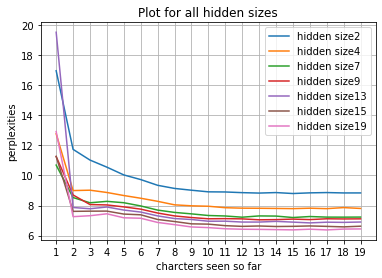

In [0]:
plt.xlabel('charcters seen so far')
plt.ylabel('perplexities')
plt.title('Plot for all hidden sizes')
for i in range(len(rnn_sizes)):
    plt.plot(characters, list_all_perplexities_for_diff_rnn[i], label = 'hidden size'+str(rnn_sizes[i]))
    
plt.grid()
plt.xticks(np.arange(min(characters), max(characters)+1, 1.0))
plt.legend()
plt.savefig("plot_for_RNNAll1.png")
plt.show()


### Observations:

I have tried running the experiment for Rnn sizes : [2, 4, 7, 9, 13, 15, 19].

Observation 1 :
As we see more characters, the perplexities reduce i.e the perplexity for a name till character i is greater than the perplexity till i+1. The perplexity decreases as we see more characters. Take for example surname : "Mathur". The perplexity till character 't' is greater than the perplexity till character 'h'. While predicting for the character 't' the seen characters are 'M' and 'a' and while predicting character 'h', the seen characters are 'M' , 'a', 't'. In the latter case the randomness is lesser compared to the former one. This is because as the RNN has seen more chracters, the randomness in selecting the next character reduces, hence the perplexity also reduces as the RNN sees more and more preceding characters.

Observation 2:
With increase in RNN sizes, the perplexities decrease. The perplexities calculated for the testset using RNN size 19 gives lessser values than the RNN with size 15 or 9 or 2. As the RNN size increases more information is learned, so the randomness in predicting the next character reduces. 

